In [30]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [2]:
df = pd.read_csv("IB_indexed.csv")

In [3]:
df = df.set_index(['UploadTime'])
df.index = pd.to_datetime(df.index)
# df.to_csv("IB_indexed.csv")

In [4]:
df_cc_resample = df.Usage_CC.resample('h').sum()

In [5]:
# split data into train, val, and test
n = len(df_cc_resample)
train_df = df_cc_resample[0:int(n*0.7)]
val_df = df_cc_resample[int(n*0.7):int(n*0.9)]
test_df = df_cc_resample[int(n*0.9):]

In [6]:
print(train_df)

UploadTime
2020-08-10 00:00:00     98754.0
2020-08-10 01:00:00    216580.0
2020-08-10 02:00:00    224280.0
2020-08-10 03:00:00    224280.0
2020-08-10 04:00:00    224164.0
                         ...   
2020-09-03 07:00:00    167124.0
2020-09-03 08:00:00    168114.0
2020-09-03 09:00:00    162420.0
2020-09-03 10:00:00    170294.0
2020-09-03 11:00:00    158286.0
Freq: H, Name: Usage_CC, Length: 588, dtype: float64


In [79]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [80]:
def split_window(sequence, steps):
    x_input, y_label = list(), list()
    for i in range(len(sequence)):
        window_end = i + steps
        if window_end == len(sequence):
            break
#         x_input.append(sequence.values[i:window_end])
        x_input.append(sequence[i:window_end])
        y_label.append(sequence[window_end])
    return np.array(x_input), np.array(y_label)

In [81]:
# split to 6-hr windows, 5 inputs and 1 label
n_steps = 4
x_train, y_train = split_window(train_df, n_steps)
x_val, y_val = split_window(val_df, n_steps)
x_test, y_test = split_window(test_df, n_steps)
# for i in range(len(x)):
#     print(x[i], y[i])

In [82]:
print(x_train)

[[-1.6500697   0.70825332  0.86237115  0.86237115]
 [ 0.70825332  0.86237115  0.86237115  0.86004937]
 [ 0.86237115  0.86237115  0.86004937  0.86237115]
 ...
 [-0.31669028 -0.31669028 -0.28162347 -0.26180832]
 [-0.31669028 -0.28162347 -0.26180832 -0.37577546]
 [-0.28162347 -0.26180832 -0.37577546 -0.21817497]]


In [83]:
# reshape [samples, timesteps] to [samples, subseq, timesteps, features]
# n_seq = # subsequences, n_steps = # timesteps/subseq 
n_features = 1
n_seq = 2
n_steps = 2
x_train = x_train.reshape(x_train.shape[0], n_seq, n_steps, n_features)
x_val = x_val.reshape(x_val.shape[0], n_seq, n_steps,n_features)
x_test = x_test.reshape(x_test.shape[0], n_seq, n_steps,n_features)

In [84]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, 
                                 activation='relu'), 
                          input_shape=(None, n_steps, n_features)))
model.add(keras.layers.TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(keras.layers.TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', # optimizer
              loss='mse',
             metrics=[tf.metrics.MeanAbsoluteError()]) # loss function # metrics to monitor

In [85]:
# fit model
model.fit(x_train, y_train, batch_size=50, epochs=200, verbose=0
          , validation_data=(x_val, y_val)
         )

In [86]:
# evaluate model using test data
results = model.evaluate(x_test, y_test, batch_size=100)

1/1 [==============================] - 0s 699us/step - loss: 0.6305 - mean_absolute_error: 0.5485


In [87]:
# generate predictions
predictions = model.predict(x_test, verbose=0)
for i in range(len(predictions)):
    print(predictions[i], y_test[i])

[0.00159972] -0.6914167756075059
[-0.06518565] -0.6129167595957592
[-0.71889025] -0.12642481946788708
[-0.33841372] 0.13309359144703065
[0.12450375] 2.5166759236262473
[1.3194674] 0.9821427192436379
[2.178025] 0.0999482506730754
[-0.20127858] -0.26236875336686294
[-0.39099908] 0.3075869977678892
[-0.17664056] 0.3195961792077281
[0.1998301] 0.33396716633073525
[0.24097456] 0.03994237407868057
[0.02310046] 0.3195961792077281
[0.01306516] 0.3195961792077281
[0.2708596] 0.3075869977678892
[0.26284465] -0.06854056492786377
[-0.06729726] -0.3369057395034628
[-0.2526675] 0.023850070949296504
[-0.13746426] -1.4220153438025025
[-0.78609705] -1.0494905355387012
[-0.77446777] -1.2181394735588382
[-1.1483678] -0.6208027887412534
[-0.53258336] -0.2532818060773849
[-0.27485445] -1.4157705694537863
[-0.26164985] 0.38400542233006385
[-0.52119195] 0.6984258077274449
[0.32395357] 0.415149232864046
[0.6199129] 0.4511767771835625
[0.42021558] -0.469246918970487
[-0.69193214] -0.8647092637843806
[-0.381178

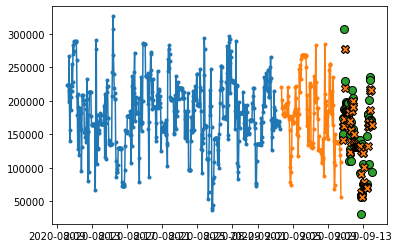

In [75]:
# blue line
plt.plot(train_df.index[n_seq*n_steps:], y_train,
        label='Inputs', marker='.', zorder=-10)
# purple line
plt.plot(val_df.index[n_seq*n_steps:], y_val,
        label='Val', marker='.', zorder=-10)
# green dots
plt.scatter(test_df.index[n_seq*n_steps:], y_test,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
# orange x's
plt.scatter(test_df.index[n_seq*n_steps:], predictions,
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

(18506.0, 18518.0)

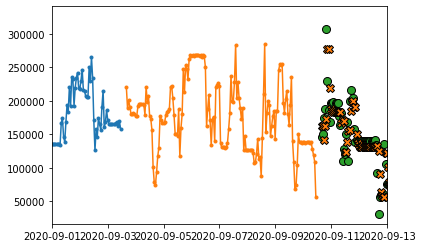

In [77]:
# blue line
plt.plot(train_df.index[n_seq*n_steps:], y_train,
        label='Inputs', marker='.', zorder=-10)
# purple line
plt.plot(val_df.index[n_seq*n_steps:], y_val,
        label='Val', marker='.', zorder=-10)
# green dots
plt.scatter(test_df.index[n_seq*n_steps:], y_test,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
# orange x's
plt.scatter(test_df.index[n_seq*n_steps:], predictions,
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)
axes = plt.gca()
axes.set_xlim([datetime.datetime.strptime("2020-09-01 00:00:00", "%Y-%m-%d %H:%M:%S"), datetime.datetime.strptime("2020-09-13 00:00:00", "%Y-%m-%d %H:%M:%S")])

(18516.0, 18518.0)

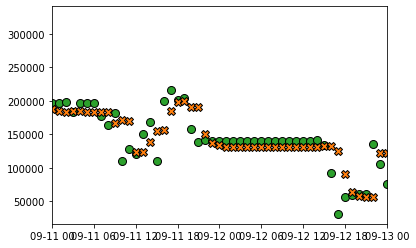

In [78]:
# blue line
plt.plot(train_df.index[n_seq*n_steps:], y_train,
        label='Inputs', marker='.', zorder=-10)
# purple line
plt.plot(val_df.index[n_seq*n_steps:], y_val,
        label='Val', marker='.', zorder=-10)
# green dots
plt.scatter(test_df.index[n_seq*n_steps:], y_test,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
# orange x's
plt.scatter(test_df.index[n_seq*n_steps:], predictions,
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)
axes = plt.gca()
axes.set_xlim([datetime.datetime.strptime("2020-09-11 00:00:00", "%Y-%m-%d %H:%M:%S"), datetime.datetime.strptime("2020-09-13 00:00:00", "%Y-%m-%d %H:%M:%S")])